File used for testing the functions in the repository

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import predict_polynomial_signal from Predicted_signal.py
from source.Losses import MSE
from source.Predicted_signal import predict_polynomial
from data.Polynomial_test import generate_polynomial_data

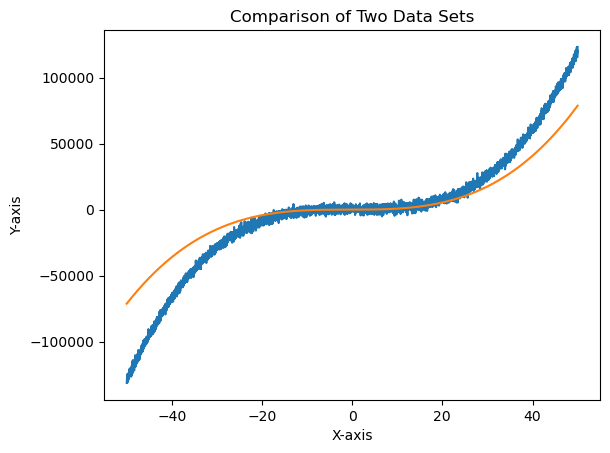

MSE: 376397838.24092937


In [9]:
# Coefficients for the polynomial (a0, a1, a2, a3, a4)
true_coefficients = [250, 2.5, -2, 1]
list = np.linspace(-50, 50, 5000)
estimated_coefficients = [0, 1.2, 1.5, 0.6]

result = generate_polynomial_data(true_coefficients, list, noise_level=2000)
prediction = predict_polynomial(estimated_coefficients, list)

plt.plot(list, result)
plt.plot(list, prediction)

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Comparison of Two Data Sets')

plt.show()

print("MSE:", MSE(result, prediction))